In [ ]:

import cv2
import math
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
    MaxPool2D,
    GlobalMaxPooling2D,
    BatchNormalization
)
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:

base_path = '/content/drive/My Drive/'
train_path = base_path+"data/uco-plant-seedlings-classification-01-2024.zip"
extract_path = base_path+'data/Extracted/'
save_extracted = base_path+'data/Save/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!mkdir extract_path

mkdir: cannot create directory ‘extract_path’: File exists


In [ ]:

from zipfile import ZipFile
with ZipFile(train_path, 'r') as zip:
  zip.extractall(extract_path)

In [ ]:

def get_data(path):
  files = glob(path)

  trainImg = []
  trainLabel = []
  j = 1
  num = len(files)

  for img in files:
      '''
      Append the image data to trainImg list.
      Append the labels to trainLabel list.
      '''
      print(str(j) + "/" + str(num))
      trainImg.append(cv2.resize(cv2.imread(img), (128, 128)))
      trainLabel.append(img.split('/')[-2])
      j += 1

  trainImg = np.asarray(trainImg)
  trainLabel = pd.DataFrame(trainLabel)
  return (trainImg, trainLabel)


path = extract_path+"train/*/*.png"
print('reading data from:',path)
trainImg, trainLabel = get_data(path)

reading data from: /content/drive/My Drive/data/Extracted/train/*/*.png


KeyboardInterrupt: 

In [ ]:

np.save(save_extracted+'trainImg.npy', trainImg)
np.save(save_extracted+'trainLabel.npy', trainLabel)

In [ ]:

trainImg = np.load(save_extracted+'trainImg.npy')
trainLabel = np.load(save_extracted+'trainLabel.npy', False, True)

trainImg.shape, trainLabel.shape

((4252, 128, 128, 3), (4252, 1))

Image name:Black-grass


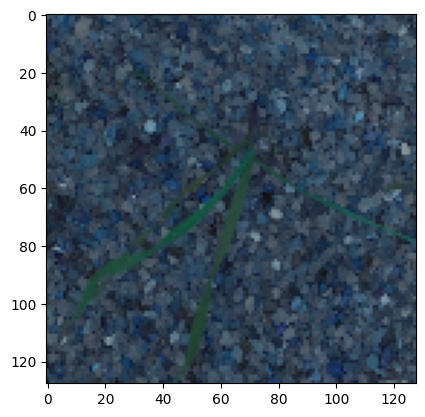

In [ ]:

i = 0
img = trainImg[i]
label = trainLabel[0][i]
print(f'Image name:{label}')
plt.imshow(img)

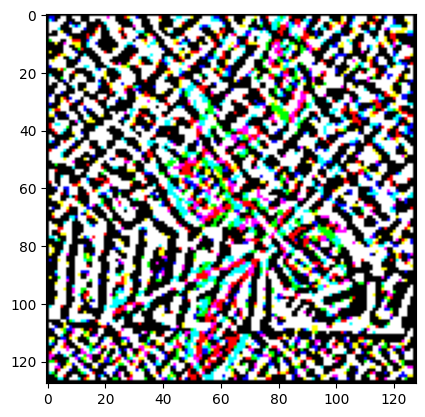

In [ ]:
sobel = cv2.Sobel(img, cv2.CV_64F, 1, 1, ksize=5)
plt.imshow(sobel)

In [ ]:
trainImg = trainImg.astype('float32')
trainImg /= 255

print(f'Shape of the Train array:{trainImg.shape}')
print(f'Minimum value in the Train Array:{trainImg.min()}')
print(f'Maximum value in the Train Array:{trainImg.max()}')

Shape of the Train array:(4252, 128, 128, 3)
Minimum value in the Train Array:0.0
Maximum value in the Train Array:1.0


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(trainImg, trainLabel, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((2976, 128, 128, 3), (1276, 128, 128, 3))

In [ ]:

X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_test.shape, X_validation.shape

((638, 128, 128, 3), (638, 128, 128, 3))

In [ ]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
y_validation = encoder.fit_transform(y_validation)

In [ ]:

y_train[0]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

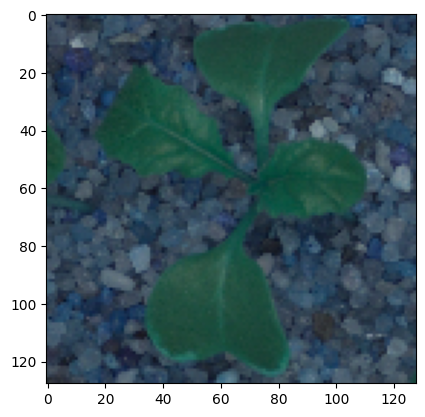

In [ ]:

plt.imshow(X_train[1], cmap='gray')

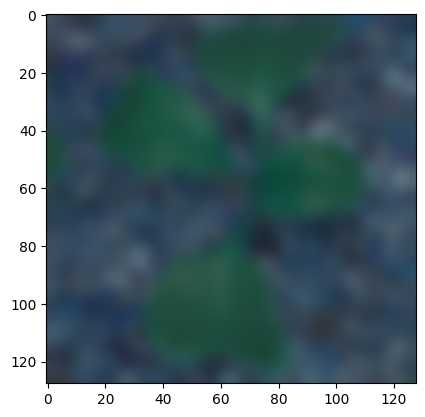

In [ ]:
plt.imshow(cv2.GaussianBlur(X_train[1], (15,15), 0))

In [ ]:

for idx, img in enumerate(X_train):
  X_train[idx] = cv2.GaussianBlur(img, (5, 5), 0)

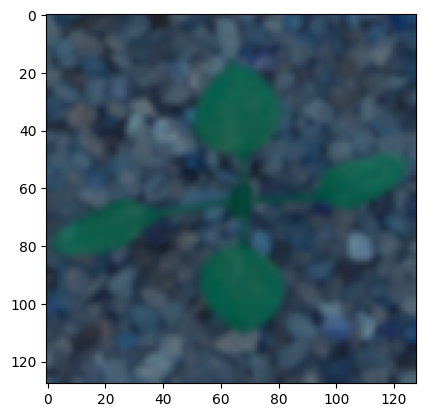

In [ ]:

plt.imshow(X_train[0], cmap='gray')

In [ ]:

for idx, img in enumerate(X_test):
  X_test[idx] = cv2.GaussianBlur(img, (5, 5), 0)

for idx, img in enumerate(X_validation):
  X_validation[idx] = cv2.GaussianBlur(img, (5, 5), 0)

In [ ]:
def create_model(input_shape, num_classes):

  model = Sequential()


  model.add(Conv2D(32, (3,3), input_shape=input_shape, padding='same', activation=tf.nn.relu))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(rate=0.25))


  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu))
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(rate=0.25))


  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(rate=0.25))


  model.add(Flatten())


  model.add(Dense(512, activation=tf.nn.relu))
  model.add(Dropout(0.5))



  model.add(Dense(units = 128, activation = tf.nn.relu))
  model.add(Dropout(0.5))


  model.add(Dense(units = num_classes, activation = tf.nn.softmax))
  return model

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=10)

In [ ]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

model = create_model(input_shape, num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                   

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=48, batch_size=100, callbacks=[callbacks])

Epoch 1/30
 6/30 [=====>........................] - ETA: 1s - loss: 2.4175 - accuracy: 0.1250

30/30 [==============================] - 15s 181ms/step - loss: 2.3652 - accuracy: 0.1374 - val_loss: 2.3599 - val_accuracy: 0.1348
Epoch 2/30
30/30 [==============================] - 2s 80ms/step - loss: 2.3470 - accuracy: 0.1398 - val_loss: 2.3462 - val_accuracy: 0.1348
Epoch 3/30
30/30 [==============================] - 3s 87ms/step - loss: 2.2127 - accuracy: 0.2117 - val_loss: 1.8957 - val_accuracy: 0.3715
Epoch 4/30
30/30 [==============================] - 2s 81ms/step - loss: 1.8403 - accuracy: 0.3532 - val_loss: 1.6221 - val_accuracy: 0.4608
Epoch 5/30
30/30 [==============================] - 2s 79ms/step - loss: 1.6143 - accuracy: 0.4120 - val_loss: 1.3981 - val_accuracy: 0.5313
Epoch 6/30
30/30 [==============================] - 2s 79ms/step - loss: 1.4728 - accuracy: 0.4610 - val_loss: 1.3219 - val_accuracy: 0.5439
Epoch 7/30
30/30 [==============================] - 2s 79ms/step - loss: 1.3562 - accuracy: 0.5309 - val_loss: 1.1529 - val_accuracy: 0.6191
Epoch 8/30
30/30 [====

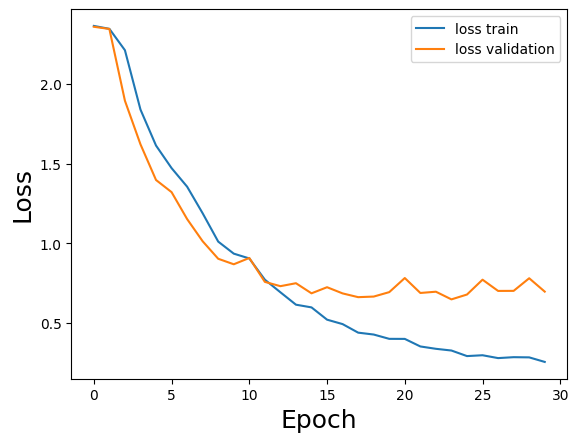

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch', fontsize=18)
plt.ylabel(r'Loss', fontsize=18)
plt.legend(('loss train','loss validation'), loc=0)

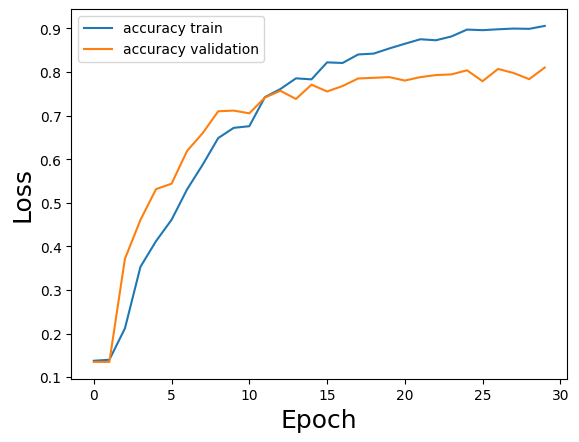

In [ ]:
# Print accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch', fontsize=18)
plt.ylabel(r'Loss', fontsize=18)
plt.legend(('accuracy train','accuracy validation'), loc=0)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss: {:.2f} \n Test accuracy: {:.2f}'.format(loss, accuracy))

loss, accuracy = model.evaluate(X_train, y_train)
print('Train loss: {:.2f} \n Train accuracy: {:.2f}'.format(loss, accuracy))

20/20 [==============================] - 1s 24ms/step - loss: 0.7207 - accuracy: 0.7978
Test loss: 0.72 
 Test accuracy: 0.80
93/93 [==============================] - 1s 8ms/step - loss: 0.1022 - accuracy: 0.9583
Train loss: 0.10 
 Train accuracy: 0.96


In [ ]:
model1 = create_model(input_shape, num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Optimizer

model1.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                 

In [ ]:
history = model1.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=18, callbacks=[callbacks])

Epoch 1/18
 5/93 [>.............................] - ETA: 2s - loss: 2.4238 - accuracy: 0.0875

93/93 [==============================] - 7s 34ms/step - loss: 2.3610 - accuracy: 0.1378 - val_loss: 2.3465 - val_accuracy: 0.1348
Epoch 2/18
93/93 [==============================] - 3s 27ms/step - loss: 1.9983 - accuracy: 0.3145 - val_loss: 1.6485 - val_accuracy: 0.4263
Epoch 3/18
93/93 [==============================] - 2s 27ms/step - loss: 1.5541 - accuracy: 0.4603 - val_loss: 1.3149 - val_accuracy: 0.5141
Epoch 4/18
93/93 [==============================] - 2s 26ms/step - loss: 1.3038 - accuracy: 0.5373 - val_loss: 1.0771 - val_accuracy: 0.6144
Epoch 5/18
93/93 [==============================] - 3s 29ms/step - loss: 1.1660 - accuracy: 0.6015 - val_loss: 1.0171 - val_accuracy: 0.6536
Epoch 6/18
93/93 [==============================] - 3s 29ms/step - loss: 1.0368 - accuracy: 0.6468 - val_loss: 0.9985 - val_accuracy: 0.6567
Epoch 7/18
93/93 [==============================] - 2s 26ms/step - loss: 0.9294 - accuracy: 0.6784 - val_loss: 0.8537 - val_accuracy: 0.7179
Epoch 8/18
93/93 [======

In [ ]:
loss, accuracy = model1.evaluate(X_test, y_test)
print('Test loss: {:.2f} \n Test accuracy: {:.2f}'.format(loss, accuracy))

loss, accuracy = model1.evaluate(X_train, y_train)
print('Train loss: {:.2f} \n Train accuracy: {:.2f}'.format(loss, accuracy))

20/20 [==============================] - 0s 10ms/step - loss: 0.7028 - accuracy: 0.7821
Test loss: 0.70 
 Test accuracy: 0.78
93/93 [==============================] - 1s 9ms/step - loss: 0.1834 - accuracy: 0.9388
Train loss: 0.18 
 Train accuracy: 0.94


In [ ]:
from keras.models import load_model
model.save(save_extracted+'final_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
 model.load_weights(save_extracted+'final_model.h5')

In [ ]:
from google.colab import drive
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from keras.models import load_model


drive.mount('/content/drive')


base_path = '/content/drive/My Drive/data/'
extract_path = os.path.join(base_path, 'Extracted/')
save_extracted = os.path.join(base_path, 'Save/')


train_categories = sorted([folder.split('/')[-1] for folder in glob(extract_path + 'train/*')])
print("Categorías de entrenamiento:", train_categories)


path = os.path.join(extract_path, "test/*.png")


model = load_model(save_extracted + 'final_model.h5')


test_images = []
for img_path in glob(path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error al cargar la imagen: {img_path}")
        continue
    img = cv2.resize(img, (128, 128))
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = img.astype('float32') / 255.0
    test_images.append(img)


test_images = np.array(test_images)


predictions = model.predict(test_images)


class_labels = train_categories
predicted_labels = [class_labels[np.argmax(pred)] for pred in predictions]


filenames = [img_path.split('/')[-1] for img_path in glob(path)]
df = pd.DataFrame({'file': filenames, 'species': predicted_labels})


df.to_csv(save_extracted + 'submission.csv', index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Categorías de entrenamiento: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherd’s Purse', 'Small-flowered Cranesbill', 'Sugar beet']
33/33 [==============================] - 0s 7ms/step
